# Identify generic genes and pathways

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change.

This notebook identifies generic genes and pathways and then evaluates if those identified are consistent with published findings.

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

  In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.


3. For each gene, aggregate statsitics across all simulated experiments
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method with the ranking found from [Crow et. al.](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), which identified a set of genes as generic based on how frequently they were found to be DE across 600 experiments
* We want to compare the ranking of pathways identified using the above method with the ranking based on the [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) data, where ranking was determined based on the fraction of 442 experiments a pathway was found to be enriched
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
import numpy as np
import pickle
import scipy.stats as ss

from rpy2.robjects import pandas2ri
from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import process, stats, ranking

pandas2ri.activate()

np.random.seed(123)

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
NN_architecture = params["NN_architecture"]
latent_dim = params["latent_dim"]
num_runs = params["num_simulated"]
project_id = params["project_id"]
metadata_col_id = params["metadata_colname"]
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
scaler_filename = params["scaler_filename"]
col_to_rank_genes = params["rank_genes_by"]
col_to_rank_pathways = params["rank_pathways_by"]
statistic = params["gsea_statistic"]
count_threshold = params["count_threshold"]
logFC_name = params["DE_logFC_name"]
pvalue_name = params["DE_pvalue_name"]

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_groups.tsv"
)

# Load metadata file with mapping between experiments and associated samples
metadata_simulate_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "recount2_metadata.tsv"
)
metadata_delimiter = "\t"
experiment_id_colname = "project"

# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

# Percentile threshold to identify generic genes
percentile_threshold = 80.0

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

pathway_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_pathway_summary_{project_id}.tsv"
)

### Simulate experiments using selected template experiment

Workflow:

1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [5]:
"""# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1]
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
simulate_expression_data.shift_template_experiment(
    normalized_compendium_filename,
    NN_architecture,
    latent_dim,
    dataset_name,
    scaler,
    metadata_simulate_filename,
    metadata_delimiter,
    experiment_id_colname,
    metadata_col_id,
    project_id,
    local_dir,
    base_dir,
    num_runs,
)"""

'# Simulate multiple experiments\n# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:\n#   - selected_simulated_data_SRP012656_<n>.txt\n#   - selected_simulated_encoded_data_SRP012656_<n>.txt\n#   - template_normalized_data_SRP012656_test.txt\n# in which "<n>" is an integer in the range of [0, num_runs-1]\nos.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)\nsimulate_expression_data.shift_template_experiment(\n    normalized_compendium_filename,\n    NN_architecture,\n    latent_dim,\n    dataset_name,\n    scaler,\n    metadata_simulate_filename,\n    metadata_delimiter,\n    experiment_id_colname,\n    metadata_col_id,\n    project_id,\n    local_dir,\n    base_dir,\n    num_runs,\n)'

### Process template and simulated experiments

* Remove samples not required for comparison
* Make sure ordering of samples matches metadata for proper comparison
* Make sure values are cast as integers for using DESeq
* Filter lowly expressed genes for using DESeq

In [6]:
"""if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_DESeq(
    mapped_template_filename,
    metadata_filename,
    processed_template_filename,
    count_threshold,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir, "pseudo_experiment", f"selected_simulated_data_{project_id}_{i}.txt"
    )
    out_simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}_processed.txt",
    )
    stats.process_samples_for_DESeq(
        simulated_filename,
        metadata_filename,
        out_simulated_filename,
        count_threshold,
        sample_id_metadata_filename,
    )"""

'if not os.path.exists(sample_id_metadata_filename):\n    sample_id_metadata_filename = None\n\nstats.process_samples_for_DESeq(\n    mapped_template_filename,\n    metadata_filename,\n    processed_template_filename,\n    count_threshold,\n    sample_id_metadata_filename,\n)\n\nfor i in range(num_runs):\n    simulated_filename = os.path.join(\n        local_dir, "pseudo_experiment", f"selected_simulated_data_{project_id}_{i}.txt"\n    )\n    out_simulated_filename = os.path.join(\n        local_dir,\n        "pseudo_experiment",\n        f"selected_simulated_data_{project_id}_{i}_processed.txt",\n    )\n    stats.process_samples_for_DESeq(\n        simulated_filename,\n        metadata_filename,\n        out_simulated_filename,\n        count_threshold,\n        sample_id_metadata_filename,\n    )'

### Differential expression analysis

The gene expression dataset is using RNA-seq so we will use DESeq2 in this case

In [7]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [8]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id,
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


In [9]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, sep="\t", header=0, index_col=0
)

selected = template_DE_stats[
    (template_DE_stats["padj"] < 0.01) & (abs(template_DE_stats["log2FoldChange"]) > 1)
]
print(selected.shape)

(3277, 6)


In [10]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir,
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     "_processed.txt",
                                     sep = "")

    get_DE_stats_DESeq(metadata_filename,
                       project_id,
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

**Validation:**
* As a quick validation, [Kim et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) found 1459 DEGs (543 upregulated and 916 downregulated) using used the Bowtie and NEUMA applications for the mapping and quantification of RNA-Seq data. They used *edgeR* with a rigorous filtering procedure based on false discovery rates, minimum applicable patient numbers, and gene expression levels was devised to select reliable sets of DEGs and DEIs (see File S8 for details). For the

* Our results found ~3K DEGs which is close enough in range given that the data was processed using different methods. recount2 resource were aligned with the splice-aware Rail-RNA aligner

### Rank genes

In [11]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


### Gene summary table

Note: Using DESeq, genes with NaN in `Adj P-value (Real)` column are those genes flagged because of the `cooksCutoff` parameter. The cook's distance as a diagnostic to tell if a single sample has a count which has a disproportionate impact on the log fold change and p-values. These genes are flagged with an NA in the pvalue and padj columns of the result table. For more information you can read [DESeq FAQs](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

In [12]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950328e-13,17569.0,10.694106,10.694106,0.002644,15704.0,88.447674,0.545455,2.071919,1.709103,22,5.044860
PRAME,PRAME,2.959784e-15,17568.0,8.664909,8.664909,0.020150,13854.0,78.027487,0.545455,2.219811,2.247804,22,2.867286
SLCO1B3,SLCO1B3,5.292942e-04,17567.0,8.325392,8.325392,0.000205,16755.0,94.367466,0.727273,2.723605,1.671155,22,3.352046
KCNC2,KCNC2,1.984004e-10,17566.0,8.230803,8.230803,0.078106,15568.0,87.681649,0.409091,2.091522,1.844182,22,3.328999
HOTAIR,HOTAIR,3.115241e-10,17565.0,8.228378,8.228378,0.000887,17311.0,97.499155,0.600000,3.252615,2.453550,20,2.027985


In [13]:
summary_gene_ranks.isna().any()

Gene ID                                 False
Adj P-value (Real)                       True
Rank (Real)                              True
abs(log2FoldChange) (Real)               True
log2FoldChange (Real)                    True
Median adj p-value (simulated)          False
Rank (simulated)                        False
Percentile (simulated)                  False
Percent DE (simulated)                  False
Mean abs(log2FoldChange) (simulated)    False
Std deviation (simulated)               False
Number of experiments (simulated)       False
Z score                                  True
dtype: bool

In [14]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep="\t")

### Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change.

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.1851682008343338
p = 3.609310754973001e-132
ci_low = 0.17010286408039038
ci_high = 0.20091386801402555


/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


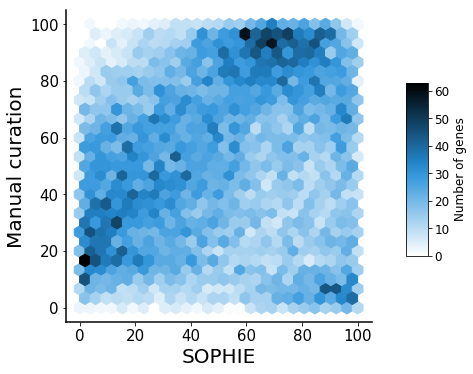

In [15]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks, DE_prior_filename, ref_gene_col, ref_rank_col, figure_filename
)

Hypergeometric test:

Given $N$ number of genes with $K$ common genes in Crow et al. SOPHIE identifies $n$ genes as being common. What is the probability that $k$ of the genes identified by SOPHIE are also common in Crow et al.? What is the probability of drawing $k$ or more concordant genes?

This was a way for us to quantify the correlation between SOPHIE and Crow et al common findings, since the correlation coefficient wasn't very convincing since we're considering all genes in addition to the common ones

In [16]:
num_Crow_genes = shared_ranking.shape[0]
num_generic_Crow_genes = shared_ranking.query(f"{ref_rank_col}>=80.0").shape[0]
num_generic_SOPHIE_genes = shared_ranking[
    shared_ranking["Percentile (simulated)"] >= percentile_threshold
].shape[0]
num_concordant_generic_genes = shared_ranking[
    (shared_ranking[ref_rank_col] >= percentile_threshold)
    & (shared_ranking["Percentile (simulated)"] >= percentile_threshold)
].shape[0]

In [17]:
print(num_Crow_genes)
print(num_generic_Crow_genes)
print(num_generic_SOPHIE_genes)
print(num_concordant_generic_genes)

17156
3678
3402
900


In [18]:
p = ss.hypergeom.sf(
    num_concordant_generic_genes,
    num_Crow_genes,
    num_generic_Crow_genes,
    num_generic_SOPHIE_genes,
)
print(p)

2.304638768942228e-15


**Takeaway:**
* Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies).
* Despite the Crow et al. data being measured on microarrays while recount2 used an RNA-seq platform, we still get good concordance
* We also noticed a set of genes in the bottom right corner of the correlation plot with a high percentile score were common DEGs in RNA-seq but not in Crow et al. We did not observe a corresponding set in the upper left corner, suggesting that RNA-seq captured the microarray-based common DEGs, but prior microarray-based reports lacked certain RNA-seq specific ones. This subset of genes was specifically differentially expressed in RNA-seq and not in array data, suggesting that platform differences underlie this effect. These genes are examined in [a separate analysis](../explore_RNAseq_only_generic_genes/)

### GSEA
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Rank all genes using DE association statistics.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression).
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES (i.e. scores based on permuted phenotype)

In [19]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [20]:
# Load pathway data
hallmark_DB_filename = params["pathway_DB_filename"]

In [21]:
%%R -i base_dir -i template_DE_stats_filename -i hallmark_DB_filename -i statistic -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt",
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, hallmark_DB_filename, statistic)

template_enriched_pathways <- as.data.frame(template_enriched_pathways[1:7])

write.table(template_enriched_pathways, file = out_filename, row.names = F, sep = "\t")

R[write to console]: Loading required package: Rcpp



In [22]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways["padj"] < 0.05].sort_values(
    by="padj"
)

(50, 7)


,pathway,pval,padj,ES,NES,nMoreExtreme,size
13,HALLMARK_E2F_TARGETS,0.000124,0.002062,0.545914,1.927526,0.0,185
18,HALLMARK_G2M_CHECKPOINT,0.000124,0.002062,0.544701,1.921359,0.0,184
19,HALLMARK_GLYCOLYSIS,0.000122,0.002062,0.519166,1.843510,0.0,196
2,HALLMARK_ALLOGRAFT_REJECTION,0.000512,0.002732,-0.393556,-1.608015,0.0,180
45,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000546,0.002732,-0.672292,-2.767638,0.0,197
44,HALLMARK_TGF_BETA_SIGNALING,0.000312,0.002732,-0.592356,-1.998634,0.0,54
34,HALLMARK_MYOGENESIS,0.000543,0.002732,-0.438242,-1.799615,0.0,195
25,HALLMARK_INFLAMMATORY_RESPONSE,0.000546,0.002732,-0.522550,-2.151190,0.0,197
23,HALLMARK_IL2_STAT5_SIGNALING,0.000541,0.002732,-0.433876,-1.781256,0.0,193
7,HALLMARK_APOPTOSIS,0.000473,0.002732,-0.415512,-1.665600,0.0,156


In [ ]:
%%R -i project_id -i local_dir -i hallmark_DB_filename -i num_runs -i statistic -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir,
                                     "DE_stats/DE_stats_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     ".txt",
                                     sep = "")

    out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt",
                     sep = "")

    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, hallmark_DB_filename, statistic)

    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways

In [ ]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir, "GSA_stats", f"GSEA_stats_template_data_{project_id}_real.txt"
)
(
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
) = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    logFC_name,
    pvalue_name,
    "GSEA",
)

### Pathway summary table

In [ ]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    "pathway",
    params,
)

summary_pathway_ranks.head()

In [ ]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep="\t")

### Compare pathway ranking

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test.


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [ ]:
# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "Hallmarks_qvalues_GSEAPreranked.csv"
)

In [ ]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(["Category"], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

In [ ]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = (powers_rank_df < 0.05).sum(axis=1) / total_num_experiments

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={
        "Fraction enriched": frac_enriched_pathways.values,
        "Powers Rank": pathway_ranks.values,
    },
    index=powers_rank_df.index,
)
powers_rank_stats_df.head()

In [ ]:
# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv",
)

powers_rank_stats_df.to_csv(
    powers_rank_processed_filename,
    sep="\t",
)

In [ ]:
figure_filename = f"pathway_ranking_{col_to_rank_pathways}.svg"

ranking.compare_pathway_ranking(
    summary_pathway_ranks, powers_rank_processed_filename, figure_filename
)

**Takeaway:**

* The above shows that there is no correlation between our ranking from SOPHIE trained on recount2 vs Powers et al. ranking (where pathways were ranked based on the fraction of experiments they had adjusted p-value < 0.05).
* These two datasets contain different platforms and different contexts